### Implementing Advantage Actor Critic for CartPole Example
#### In Addition: Entropy Bonus for Exploration

Importing necessary dependencies:

In [1]:
import os
import random
from collections import namedtuple, deque
from itertools import count

import numpy as np
import pandas as pd
from plotnine import *
from mizani.formatters import comma_format
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

ModuleNotFoundError: No module named 'gym'

### The Game

In [2]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [3]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

Observation space is four continuous measurements.

In [4]:
env.action_space

Discrete(2)

Action space is discrete range from 0 to 1, i.e. left and right.

In [5]:
env.reset()

(array([0.02610479, 0.04398819, 0.04971935, 0.00347209], dtype=float32), {})

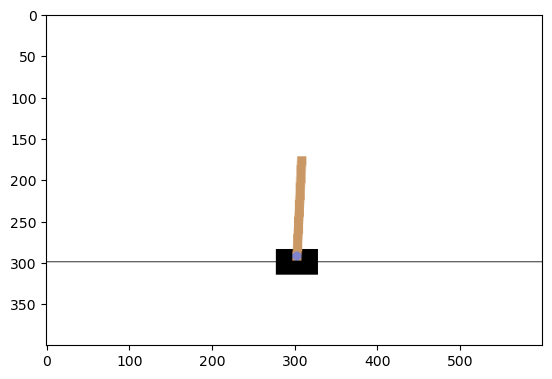

In [6]:
plt.imshow(env.render())

### Writing an A2C Algorithm with PyTorch

In [9]:
env = gym.make('CartPole-v1')
env.reset()

(array([ 0.04441297, -0.03055383, -0.00520976,  0.01191806], dtype=float32),
 {})

In [10]:
GAMMA = 0.99
BETA = 0.05
LEARNING_RATE = 0.003

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

In [11]:
class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)

        # actor's layer
        self.action_head = nn.Linear(128, 2)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = [] # for log probs from actor and values from critic
        self.rewards = []

        # Entropies for entropy bonus
        self.entropies = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        # first, pass the observation through the first 
        # fully connected layer with relu activation
        x = F.relu(self.affine1(x))

        # then, two outputs from the same network that 
        # has only one input (state)
        # First: actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. softmax output over the action space
        # 2. the value from state s_t
        return action_prob, state_values

In [12]:
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
eps = np.finfo(np.float32).eps.item() # used to avoid dividing by zero error

In [13]:
def select_action(state, model):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # Calculate entropy bonus
    entropy = -torch.sum(probs * torch.log(probs))
    model.entropies.append(entropy)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    # save log probabilities outputted by actor head 
    # and state value outputted by critic head to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # return the action to take (left or right)
    return action.item()

In [14]:
def finish_episode(model):
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions # log probs and respective actions
    entropies = model.entropies # entropies for entropy bonus
    policy_losses = [] # list to save actor (policy) loss for each step in episode
    value_losses = [] # list to save critic (value) loss for each step in episode
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    # Those are the Q-Values from the unrolled rewards until the final state
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + GAMMA * R
        returns.insert(0, R) # insert at beginning of list

    returns = torch.tensor(returns, dtype=torch.float32)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum() - BETA * torch.stack(entropies).mean()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards, episode actions and log probs as well as entropies
    del model.rewards[:]
    del model.saved_actions[:]
    del model.entropies[:]

The actual training loop:

In [252]:
min_episodes = 50
running_rewards = deque(maxlen=min_episodes)
ep_reward_history = []
best_reward = None

# run infinitely many episodes (until break condition is met)
for episode_idx in count(1):

    # reset environment and episode reward at the beginning of episode
    state, _ = env.reset()
    ep_reward = 0

    # for each episode, only run 9999 steps so that we don't
    # infinite loop while learning (agent getting stuck)
    for t in range(1, 10000):

        # select action from policy (and save model output to buffer)
        action = select_action(state, model)

        # take the action
        state, reward, terminated, truncated, _ = env.step(action)

        # save the rewards at each step taken in the episode in the buffer
        # This will be used for calculating
        model.rewards.append(reward)
        ep_reward += reward

        if terminated or truncated:
            running_rewards.append(ep_reward)
            ep_reward_history.append(ep_reward)
            break

    # perform backprop
    finish_episode(model)

    # log results only if enough episodes have been played
    if episode_idx < min_episodes:
        continue

    # Calculate mean reward of past min_episodes
    running_reward = np.mean(running_rewards)
    if episode_idx % 100 == 0:
        print(f"Episode {episode_idx}\tLast reward: {ep_reward:.2f}\tAverage reward: {running_reward:.2f}")

    # check if we have "solved" the cart pole problem
    if running_reward >= 500: # env.spec.reward_threshold:
        print(f"Solved at Episode {episode_idx}! Average reward is now {running_reward}")
        break

Episode 100	Last reward: 83.00	Average reward: 56.58
Episode 200	Last reward: 177.00	Average reward: 218.04
Episode 300	Last reward: 500.00	Average reward: 441.10
Episode 400	Last reward: 500.00	Average reward: 466.32
Episode 500	Last reward: 500.00	Average reward: 438.94
Solved at Episode 565! Average reward is now 500.0


c:\Users\STEIM\AppData\Local\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 24 rows containing missing values.


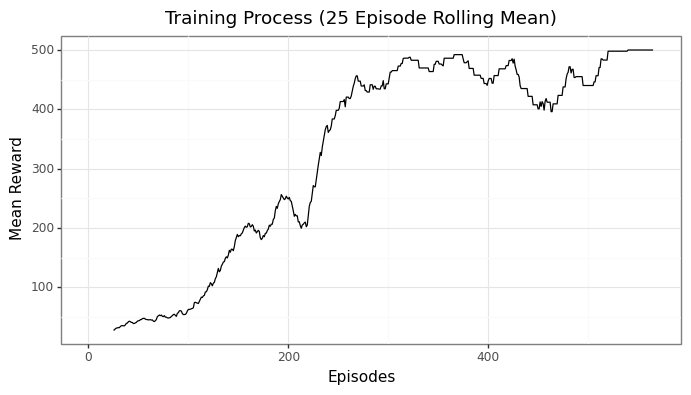

<ggplot: (177557684444)>

In [256]:
(
    ggplot(data=(pd.DataFrame({'Episodes': np.arange(1, episode_idx + 1),
                               'Rewards': ep_reward_history})
                 .assign(Rewards=lambda x: x['Rewards'].rolling(25).mean())),
           mapping=aes(x='Episodes', y='Rewards')) +
    geom_line() +
    labs(title='Training Process (25 Episode Rolling Mean)',
         y='Mean Reward') +
    theme_bw() +
    theme(figure_size=[8, 4])
)


In [257]:
torch.save(model.state_dict(), f='trained_model_a2c_entropy_bonus.pt')

### Letting the Trained Agent Play

Start by loading the agent and initialising the environment:

In [15]:
# Defining the environment
env = gym.make('CartPole-v1', render_mode='rgb_array')
obs_size = env.observation_space.shape[0] # define sizes for NN
n_actions = env.action_space.n


# Loading the model
trained_agent = Policy() # instance of model
trained_agent.load_state_dict(torch.load("trained_model_a2c_entropy_bonus.pt"))
trained_agent.eval()

Policy(
  (affine1): Linear(in_features=4, out_features=128, bias=True)
  (action_head): Linear(in_features=128, out_features=2, bias=True)
  (value_head): Linear(in_features=128, out_features=1, bias=True)
)

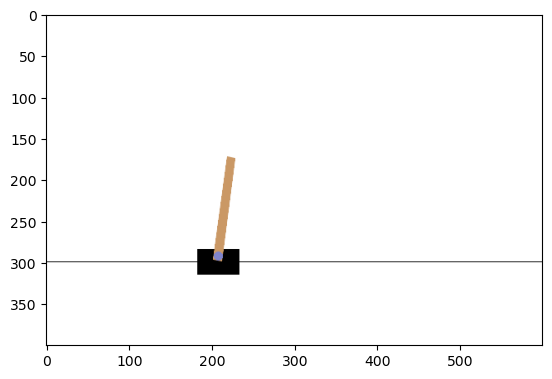

Total Episode Reward: 500.0


In [17]:
obs, _ = env.reset()
total_reward = 0.0

for step_idx in count(1):
    action = select_action(obs, trained_agent)
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward

    if step_idx % 8 == 0:
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()

    if terminated or truncated:
        print(f"Total Episode Reward: {total_reward}")
        break

Success, the agent now stays more in the middle, which is great, because it's exactly what I aimed to achieve with the entropy bonus!